In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_01b import *
from fastai.vision import *
from fastai.utils.collect_env import *

In [3]:
show_install(True)



```text
=== Software === 
python        : 3.7.5
fastai        : 1.0.59
fastprogress  : 0.1.22
torch         : 1.3.1
nvidia driver : 418.67
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.9.0-11-amd64-x86_64-with-debian-9.11
distro        : #1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)
conda env     : fastai2
python        : /opt/anaconda3/envs/fastai2/bin/python
sys.path      : /home/jupyter/xview2comp
/opt/anaconda3/envs/fastai2/lib/python37.zip
/opt/anaconda3/envs/fastai2/lib/python3.7
/opt/anaconda3/envs/fastai2/lib/python3.7/lib-dynload

/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages
/home/jupyter/fastai2
/home/jupyter/fastcore
/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/IPython/extensions
/home/jupyter/.ipython
../course-v3/nbs/dl2

Mon Dec 23 10:14:06 2019       
+------------------------

## Load Data

In [6]:
nsets = ['train', 'tier3']

In [8]:
SOURCE = Path('data')

In [16]:
fnames = []
for n in nsets:
    paths = pre_img_fpaths(get_image_files(SOURCE/n/'images'))
    fnames.extend(paths)

In [24]:
lbl_names = [img2bmask_fpath(o) for o in fnames]

In [20]:
len(fnames), fnames[:3]

(9168,
 [PosixPath('data/train/images/socal-fire_00001272_pre_disaster.png'),
  PosixPath('data/train/images/mexico-earthquake_00000125_pre_disaster.png'),
  PosixPath('data/train/images/socal-fire_00000301_pre_disaster.png')])

Note that if your mask is already like small values like 1, 2, 3, etc., instead of 255, etc., don't set `div` to True when loading the masks, as this zeroes everything.  See here:

In [25]:
# step-by-step
fname = lbl_names[-11]
PIL.Image.open(fname)
PIL.Image.open(fname).convert('L')

pil2tensor(PIL.Image.open(fname).convert('L'), np.int32).sum()
#pil2tensor(PIL.Image.open(fname).convert('L'), np.int32).div(255.).sum()


tensor(0)

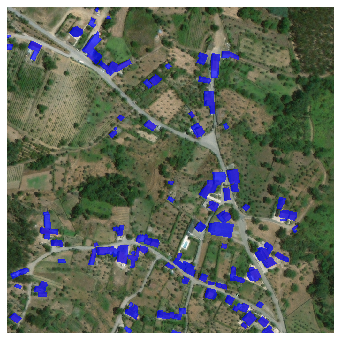

In [28]:
img_f = fnames[-5]
img = open_image(img_f)
mask = open_mask(img2bmask_fpath(img_f))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
img.show(ax=ax)
(mask).show(ax=ax, alpha=.7, cmap=CMAP, vmax=4)

## Make DataBunch

In [29]:
size = 1024
bs = 2

In [30]:
codes = np.array(['Empty', 'Building'])

In [31]:
#export
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

In [32]:
#export
def get_random_val_idx(n, val_pct=.1):
    return np.random.permutation(n)[:int(val_pct * n)]

In [33]:
val_idx = get_random_val_idx(len(fnames))

In [34]:
src = (SegItemListCustom(fnames)
       .split_by_idx(val_idx)
       .label_from_func(img2bmask_fpath, classes=codes))

In [35]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [36]:
! nvidia-smi

Mon Dec 23 10:28:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

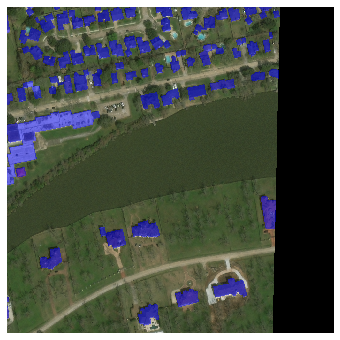

In [37]:
idx = 7
_, ax = plt.subplots(figsize=(6, 6))
data.train_ds.x[idx].show(ax)
data.train_ds.y[idx].show(ax, alpha=.5, cmap=CMAP, vmax=4)

In [38]:
data.train_ds.x[5].data.mean(), data.train_ds.x[5].data.std()

(tensor(0.3228), tensor(0.1132))

In [39]:
data.train_ds.y[5].data.unique()

tensor([0])

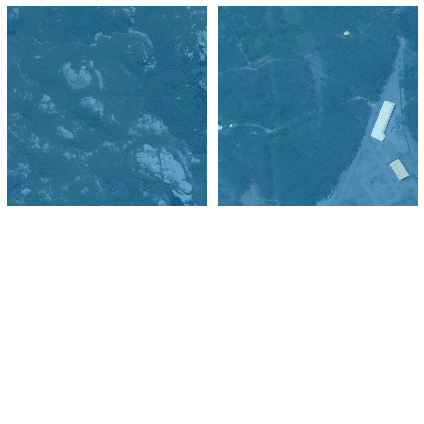

In [42]:
data.show_batch(2, figsize=(6, 6), alpha=.7)

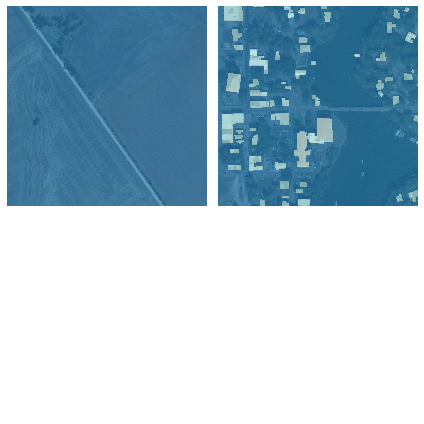

In [43]:
data.show_batch(2, figsize=(6, 6), ds_type=DatasetType.Valid, alpha=.7)

In [44]:
data.classes

array(['Empty', 'Building'], dtype='<U8')

## Normalization

In [23]:
data.train_ds.x[6].data.mean()

tensor(0.2823)

In [24]:
data.train_ds.y[6].data.unique()

tensor([0, 1])

In [25]:
xb, yb = next(iter(data.train_dl))

In [26]:
xb.min(), xb.max(), xb.mean(), xb.std()

(tensor(-2.1179, device='cuda:0'),
 tensor(2.6400, device='cuda:0'),
 tensor(-0.8172, device='cuda:0'),
 tensor(0.6079, device='cuda:0'))

In [27]:
del xb, yb

## Custom Loss

In [45]:
#export
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)


In [46]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()


In [47]:
metrics = [dice_loss, accuracy_thresh, dice]

In [48]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [49]:
learn.metrics

[<function __main__.dice_loss(input, target)>,
 <function fastai.metrics.accuracy_thresh(y_pred: torch.Tensor, y_true: torch.Tensor, thresh: float = 0.5, sigmoid: bool = True) -> <function NewType.<locals>.new_type at 0x7f25f5a05b00>>,
 <function fastai.metrics.dice(input: torch.Tensor, targs: torch.Tensor, iou: bool = False, eps: float = 1e-08) -> <function NewType.<locals>.new_type at 0x7f25f5a05b00>>]

In [50]:
learn.loss_func = combo_loss

In [51]:
! nvidia-smi

Mon Dec 23 10:30:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |    807MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


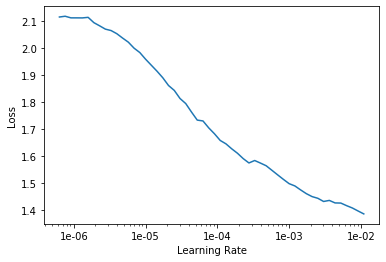

In [53]:
learn.recorder.plot()

In [54]:
lr = 1e-3

In [55]:
learn.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.518333,0.357296,0.316549,0.984700,0.729657,1:00:46
1,0.399524,0.364160,0.320033,0.985107,0.722180,1:00:41
2,0.385029,0.333550,0.291362,0.985727,0.745353,1:00:40
3,0.291937,0.301323,0.267361,0.986866,0.777079,1:00:40
4,0.314504,0.290026,0.258095,0.987739,0.797817,1:00:40


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



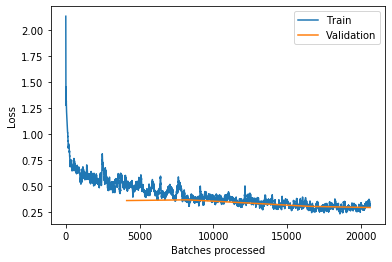

In [56]:
learn.recorder.plot_losses()

In [57]:
learn.save('sz1024_bs2_resnet34_5epochcycle_maxlr1e-3');

In [58]:
learn.load('sz1024_bs2_resnet34_5epochcycle_maxlr1e-3');

In [59]:
learn.unfreeze()

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


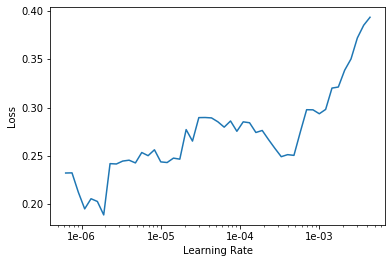

In [61]:
learn.recorder.plot()

In [62]:
lr = 1e-3

In [63]:
learn.fit_one_cycle(cyc_len=8, max_lr=slice(1e-6,lr/10))

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.276218,0.289165,0.256534,0.987729,0.793540,1:02:57
1,0.328775,0.286256,0.255417,0.988038,0.797989,1:02:57
2,0.295759,0.291465,0.258417,0.987237,0.785745,1:02:57
3,0.275305,0.275250,0.245544,0.988467,0.796463,1:02:58
4,0.301288,0.276843,0.246793,0.988291,0.804059,1:02:58
5,0.217335,0.274587,0.245429,0.988542,0.809943,1:02:59
6,0.273878,0.266722,0.238198,0.988836,0.809238,1:02:59
7,0.250624,0.266027,0.238206,0.988957,0.809379,1:02:58


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

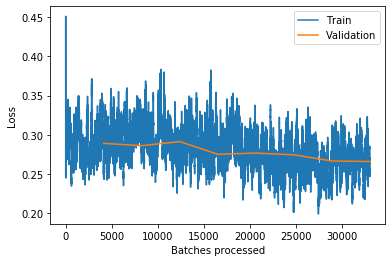

In [64]:
learn.recorder.plot_losses()

In [65]:
learn.save(f'sz1024_bs2_resnet34_8epochcycle_maxlr1e-3_stage2')
learn.load(f'sz1024_bs2_resnet34_8epochcycle_maxlr1e-3_stage2');

In [91]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, lr/10))

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.259021,0.260118,0.231748,0.989048,0.811136,1:03:00


In [92]:
learn.save(f'sz1024_bs2_resnet34_1epochcycle_maxlr1e-3_stage3')
learn.load(f'sz1024_bs2_resnet34_1epochcycle_maxlr1e-3_stage3');

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, lr/10))

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


## Predict batch and look at results

In [93]:
learn.model.eval();

In [94]:
learn.model.training

False

In [96]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid, )

In [97]:
outputs.shape

torch.Size([2, 2, 1024, 1024])

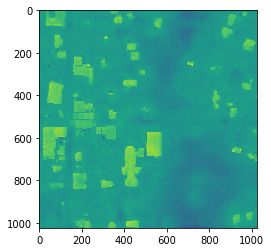

In [98]:
plt.imshow(outputs[1][1].numpy());

In [99]:
#export
def pred2mask(pred):
    return (pred[:,1,None].sigmoid() > .95).long()

In [100]:
predmask = pred2mask(outputs)

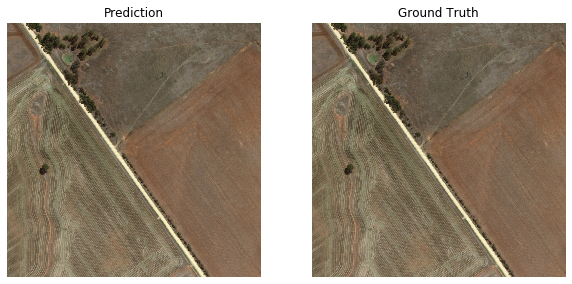

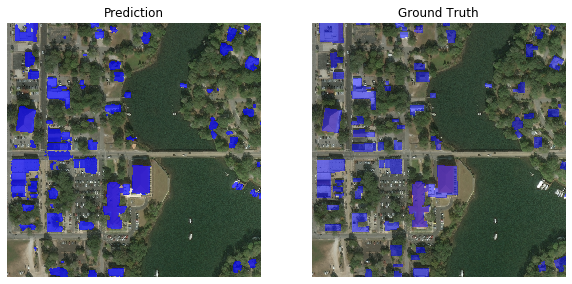

In [101]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    ax1.set_title('Prediction')
    data.valid_ds.x[i].show(ax=ax1)
    ax1.imshow(predmask[i,0], alpha=0.7, cmap=CMAP, vmax=4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.5, cmap=CMAP, vmax=4)

In [102]:
! nvidia-smi

Tue Dec 24 02:48:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    34W / 250W |  14651MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Predict on test sample(s)

In [103]:
SRC_TEST = Path('data/test')
SRC_TEST.ls()

[PosixPath('data/test/images')]

In [104]:
fnames = get_image_files(SRC_TEST/'images')
npreimgs = pre_img_fpaths(fnames)
len(npreimgs), len(fnames)

(933, 1866)

In [110]:
idx = 564

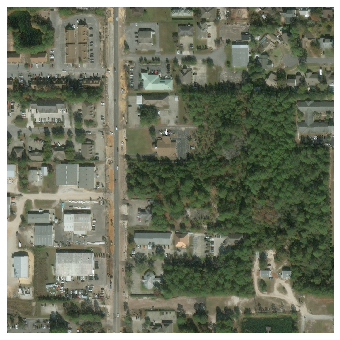

In [111]:
preimg = open_image(npreimgs[idx])
preimg.show(figsize=(6, 6))

In [112]:
tfms[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

In [113]:
y, pred, raw_pred = learn.predict(preimg)

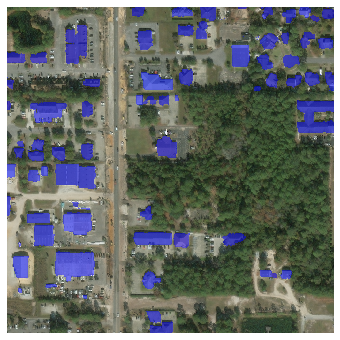

In [114]:
_, ax = plt.subplots(figsize=(6, 6))
preimg.show(ax)
y.show(ax, alpha=.5, cmap=CMAP, vmax=4)

In [56]:
! nvidia-smi

Wed Dec 18 07:52:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    31W / 250W |   7489MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# -fin

In [1]:
! python notebook2script.py 02b_segment_features.ipynb

Converted 02b_segment_features.ipynb to xview2comp/nb_02b.py
